In [2]:
!pip install easyocr
!pip install googletrans

     |████████████████████████████████| 63.6 MB 42 kB/s 
     |████████████████████████████████| 47.6 MB 54 kB/s 


     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 1.2 MB 14.6 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 65 kB 3.3 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-py3-none-any.whl size=15734 sha256=32d9d743d10a686da8150ba086714e11a024d34f39eb7d6c1d85c88ac1643e5d
  Stored in directory: /root/.cache/pip/wheels/20/da/eb/a54579056f265eede0417df537dd56d3df5b9eb2b25df0003d
Successfully built googletrans


4.1.2


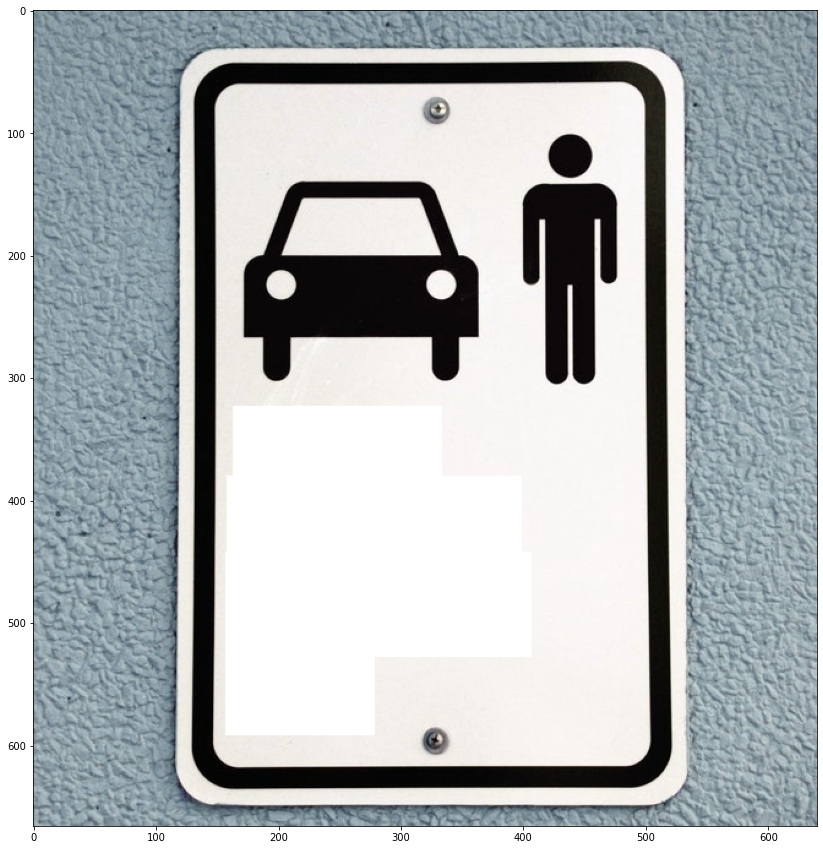

Text_list : ['Patient', 'Pick-Up &', 'Discharge', 'Only']
Tranlated_texts : ['환자', '픽업 &', '퇴원', '오직']


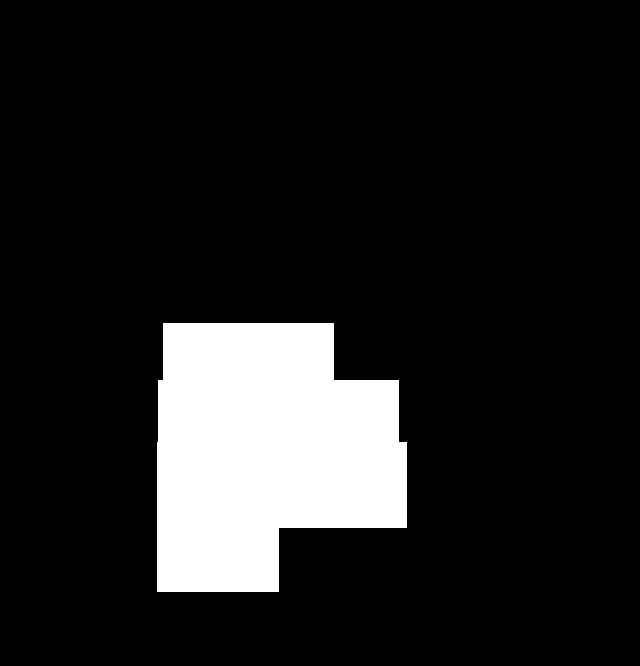

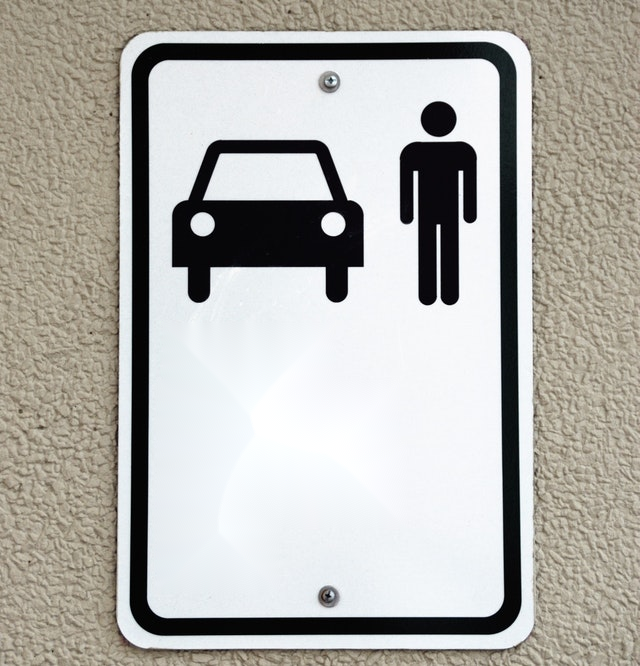

In [5]:
import cv2
import matplotlib.pyplot as plt
import easyocr
import sys
import googletrans
from typing import List
import requests
import pprint

from google.colab.patches import cv2_imshow
import numpy as np

from PIL import Image 
from PIL import ImageFont
from PIL import ImageDraw


# Press Shift+F10 to execute it or replace it with your code.
# Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

print(cv2.__version__)

# 이미지 파일 경로
file_path = r'patient.jpg'
img = cv2.imread(file_path, cv2.IMREAD_COLOR)

CLIENT_ID = "MawiiHEojSbWlRvZjWEM"
CLIENT_SECRET = "gY1PNWHP54"

if img is None:
    print('Image load failed!')
    sys.exit()


# 이미지 출력함수
def display(img):
    # img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    plt.show()


def cleanup_text(text):
    # strip out non-ASCII text so we can draw the text on the image
    # using OpenCV
    return "".join([c if ord(c) < 128 else "" for c in text]).strip()


def easy_ocr_result(img, language='en', draw=True, text=False):
    reader = easyocr.Reader([language])
    results = reader.readtext(img)

    # 바운딩박스 리스트
    bbox_list = []
    # 텍스트 리스트
    text_list = []

    if draw == False: # 원래 이미지만 출력
        display(img)

    elif draw == True and text == False: # 이미지에 바운딩 박스그리기
        img2 = img.copy()
        # img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
        for (bbox, text, prob) in results:
            # display the OCR'd text and associated probability
            # print("[INFO] {:.4f}: {}".format(prob, text))

            bbox_list.append(bbox)
            text_list.append(text)
            # unpack the bounding box
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))
            # cleanup the text and draw the box surrounding the text along
            # with the OCR'd text itself
            cv2.rectangle(img2, tl, br, (255, 255, 255), -1) # white box

        # show the output image
        display(img2)



    elif draw == True and text == True:  # 이미지에 바운딩 + 인식한 글자
        img2 = img.copy()
        # img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

        for (bbox, text, prob) in results:
            # display the OCR'd text and associated probability
            # print("[INFO] {:.4f}: {}".format(prob, text))

            bbox_list.append(bbox)
            text_list.append(text)

            # unpack the bounding box
            (tl, tr, br, bl) = bbox
            tl = (int(tl[0]), int(tl[1]))
            tr = (int(tr[0]), int(tr[1]))
            br = (int(br[0]), int(br[1]))
            bl = (int(bl[0]), int(bl[1]))
            # cleanup the text and draw the box surrounding the text along
            # with the OCR'd text itself
            text = cleanup_text(text)
            cv2.rectangle(img2, tl, br, (255, 0, 0), 2)
            cv2.putText(img2, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

        # show the output image
        display(img2)
    return bbox_list, text_list


def translate_texts(texts: List[str], type='google') -> List[str]:
    global tranlated_texts
    if type == 'google':
        translator = googletrans.Translator()
        tranlated_texts = [
            translator.translate(text=text, src='en', dest='ko').text
            for text in texts
        ]
    elif type == 'naver':
        url = "https://openapi.naver.com/v1/papago/n2mt"
        header = {"X-Naver-Client-Id": CLIENT_ID, "X-Naver-Client-Secret": CLIENT_SECRET}
        tranlated_texts = []
        for text in texts:
            data = {'text': text, 'source': 'en', 'target': 'ko'}
            response = requests.post(url, headers=header, data=data)
            rescode = response.status_code
            if rescode == 200:
                t_data = response.json()
                tranlated_texts.append(t_data['message']['result']['translatedText'])
            else:
                print("Error Code:", rescode)

    return tranlated_texts


# Press the green button in the gutter to run the script.
if __name__ == '__main__':
    bbox_list, text_list = easy_ocr_result(img)
    print('Text_list :', text_list)
    tranlated_texts: List[str] = translate_texts(texts=text_list, type='naver')
    print(f'Tranlated_texts : {tranlated_texts}')

# ------------------------------------
# 바운딩 박스만 White로 바꾸고 아래것 실행 하면됩니다, bbox_list
# 글자 폰트는 한글 지원되는 것만 가능 (한글번역이라)




# make mask : step 1
# Load image
img = cv2.imread('patient.jpg')

# Initialize blank mask image of same dimensions for drawing the shapes
shapes = np.zeros_like(img, np.uint8)

# Draw shapes
cv2.rectangle(shapes, tuple(bbox_list[0][0]),tuple(bbox_list[0][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[1][0]),tuple(bbox_list[1][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[2][0]),tuple(bbox_list[2][2]), (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, tuple(bbox_list[3][0]),tuple(bbox_list[3][2]), (255, 255, 255), cv2.FILLED)

# Generate output by blending image with shapes image, using the shapes
# images also as mask to limit the blending to those parts
out = img.copy()
alpha = 0.01
mask = shapes.astype(bool)
out[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]

# Visualization & Save
# cv2_imshow(shapes)
cv2.imwrite("shapes.jpg", shapes)




# inpaint : step2
# img = cv2.imread('target.jpg')
img = cv2.imread('patient.jpg')
mask = cv2.imread('shapes.jpg',0)
dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

# Visualization & Save
# cv2_imshow(dst)
cv2.imwrite("inpaint.jpg", dst)



# rewrite : step3
# Font
font = ImageFont.truetype("NotoSansKR-Black.otf", 58)
img = Image.open('inpaint.jpg')

draw = ImageDraw.Draw(img)

draw.text(bbox_list[0][0], tranlated_texts[0], (0,0,0), font=font)
draw.text(bbox_list[1][0], tranlated_texts[1], (0,0,0), font=font)
draw.text(bbox_list[2][0], tranlated_texts[2], (0,0,0), font=font)
draw.text(bbox_list[3][0], tranlated_texts[3], (0,0,0), font=font)

img.show()
img.save("img_text.jpg")



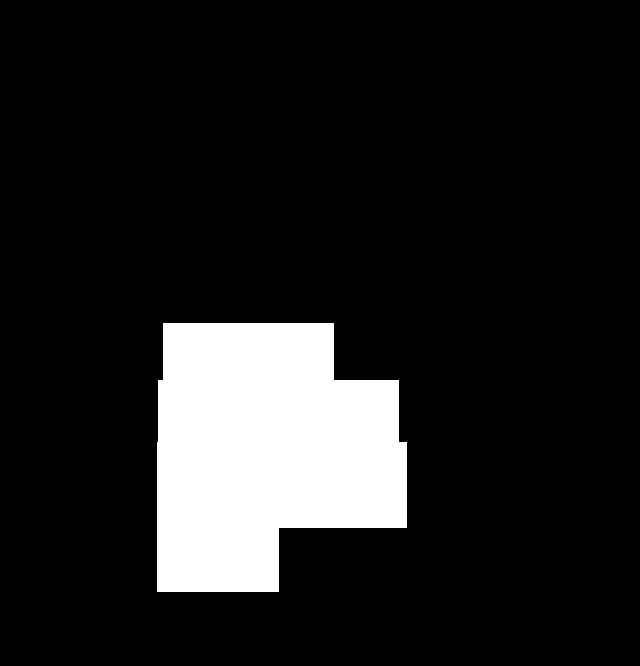

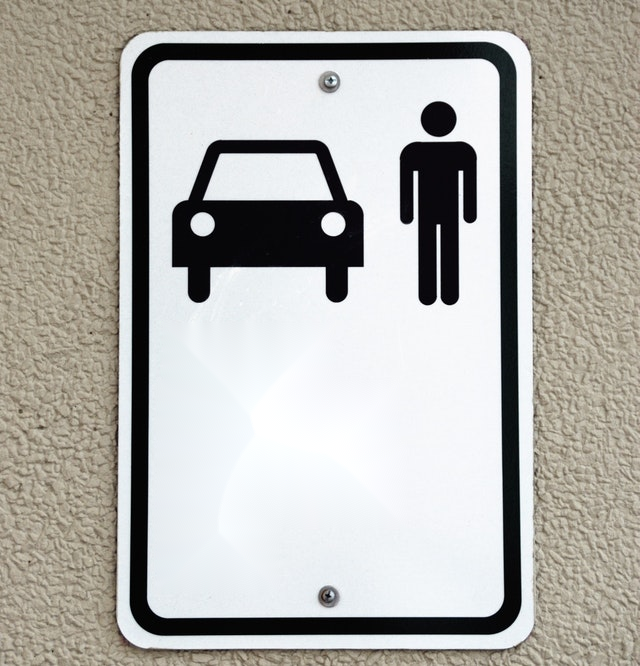

In [4]:
# 바운딩 박스만 White로 바꾸고 아래것 실행 하면됩니다, bbox_list
# 글자 폰트는 한글 지원되는 것만 가능 (한글번역이라)
from google.colab.patches import cv2_imshow

import numpy as np

from PIL import Image 
from PIL import ImageFont
from PIL import ImageDraw



# make mask : step 1
# Load image
img = cv2.imread('patient.jpg')

# Initialize blank mask image of same dimensions for drawing the shapes
shapes = np.zeros_like(img, np.uint8)

# Draw shapes
cv2.rectangle(shapes, bbox_list[0][0],bbox_list[0][2], (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, bbox_list[1][0],bbox_list[1][2], (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, bbox_list[2][0],bbox_list[2][2], (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, bbox_list[3][0],bbox_list[3][2], (255, 255, 255), cv2.FILLED)

# Generate output by blending image with shapes image, using the shapes
# images also as mask to limit the blending to those parts
out = img.copy()
alpha = 0.01
mask = shapes.astype(bool)
out[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]

# Visualization & Save
cv2_imshow(shapes)
cv2.imwrite("shapes.jpg", shapes)




# inpaint : step2
# img = cv2.imread('target.jpg')
img = cv2.imread('patient.jpg')
mask = cv2.imread('shapes.jpg',0)
dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

# Visualization & Save
cv2_imshow(dst)
cv2.imwrite("inpaint.jpg", dst)



# rewrite : step3
# Font
font = ImageFont.truetype("NotoSansKR-Black.otf", 58)
img = Image.open('inpaint.jpg')

draw = ImageDraw.Draw(img)

draw.text(bbox_list[0][0], tranlated_texts[0], (0,0,0), font=font)
draw.text(bbox_list[1][0], tranlated_texts[1], (0,0,0), font=font)
draw.text(bbox_list[2][0], tranlated_texts[2], (0,0,0), font=font)
draw.text(bbox_list[3][0], tranlated_texts[3], (0,0,0), font=font)

img.show()
img.save("img_text.jpg")

In [ ]:
# ##### 끝

In [4]:
# import cv2
# import matplotlib.pyplot as plt
# import easyocr
# import sys
# import googletrans
# from typing import List
# import requests
# import pprint

# # Press Shift+F10 to execute it or replace it with your code.
# # Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

# print(cv2.__version__)

# # 이미지 파일 경로
# file_path = r'patient.jpg'
# img = cv2.imread(file_path, cv2.IMREAD_COLOR)

# CLIENT_ID = "MawiiHEojSbWlRvZjWEM"
# CLIENT_SECRET = "gY1PNWHP54"

# if img is None:
#     print('Image load failed!')
#     sys.exit()


# # 이미지 출력함수
# def display(img):
#     # img_rgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
#     plt.figure(figsize=(15, 15))
#     plt.imshow(img)
#     plt.show()


# def cleanup_text(text):
#     # strip out non-ASCII text so we can draw the text on the image
#     # using OpenCV
#     return "".join([c if ord(c) < 128 else "" for c in text]).strip()


# def easy_ocr_result(img, language='en', draw=True, text=False):
#     reader = easyocr.Reader([language])
#     results = reader.readtext(img)

#     # 바운딩박스 리스트
#     bbox_list = []
#     # 텍스트 리스트
#     text_list = []

#     if draw == False: # 원래 이미지만 출력
#         display(img)

#     elif draw == True and text == False: # 이미지에 바운딩 박스그리기
#         img2 = img.copy()
#         # img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
#         for (bbox, text, prob) in results:
#             # display the OCR'd text and associated probability
#             # print("[INFO] {:.4f}: {}".format(prob, text))

#             bbox_list.append(bbox)
#             text_list.append(text)
#             # unpack the bounding box
#             (tl, tr, br, bl) = bbox
#             tl = (int(tl[0]), int(tl[1]))
#             tr = (int(tr[0]), int(tr[1]))
#             br = (int(br[0]), int(br[1]))
#             bl = (int(bl[0]), int(bl[1]))
#             # cleanup the text and draw the box surrounding the text along
#             # with the OCR'd text itself
#             cv2.rectangle(img2, tl, br, (255, 255, 255), -1) # white box -1

#         # show the output image
#         display(img2)
#         cv2.imwrite("target.jpg", img2) # img2 파일저장 "target.jpg"

#     elif draw == True and text == True:  # 이미지에 바운딩 + 인식한 글자
#         img2 = img.copy()
#         # img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)

#         for (bbox, text, prob) in results:
#             # display the OCR'd text and associated probability
#             # print("[INFO] {:.4f}: {}".format(prob, text))

#             bbox_list.append(bbox)
#             text_list.append(text)

#             # unpack the bounding box
#             (tl, tr, br, bl) = bbox
#             tl = (int(tl[0]), int(tl[1]))
#             tr = (int(tr[0]), int(tr[1]))
#             br = (int(br[0]), int(br[1]))
#             bl = (int(bl[0]), int(bl[1]))
#             # cleanup the text and draw the box surrounding the text along
#             # with the OCR'd text itself
#             text = cleanup_text(text)
#             cv2.rectangle(img2, tl, br, (255, 0, 0), 2)
#             cv2.putText(img2, text, (tl[0], tl[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

#         # show the output image
#         display(img2)
#     return bbox_list, text_list
# # Press the green button in the gutter to run the script.
# if __name__ == '__main__':
#     bbox_list, text_list = easy_ocr_result(img)
#     print('bbox_list :', bbox_list)
#     print('text_list :', text_list)

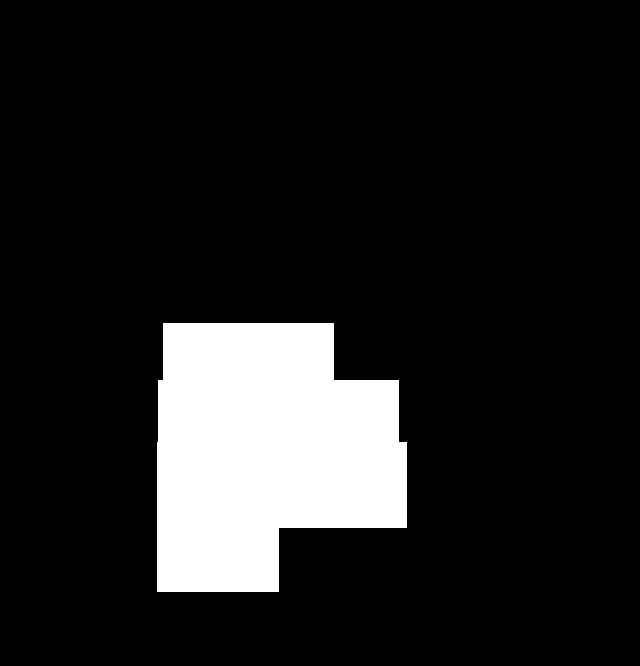

True

In [20]:
# shapes
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

# Load image
img = cv2.imread('patient.jpg')

# Initialize blank mask image of same dimensions for drawing the shapes
shapes = np.zeros_like(img, np.uint8)

# Draw shapes
cv2.rectangle(shapes, bbox_list[0][0],bbox_list[0][2], (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, bbox_list[1][0],bbox_list[1][2], (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, bbox_list[2][0],bbox_list[2][2], (255, 255, 255), cv2.FILLED)
cv2.rectangle(shapes, bbox_list[3][0],bbox_list[3][2], (255, 255, 255), cv2.FILLED)


# cv2.rectangle(shapes, (163, 323), (333, 385), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (158, 380), (398, 458), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (157, 442), (406, 527), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (157, 511), (278, 591), (255, 255, 255), cv2.FILLED)


# Generate output by blending image with shapes image, using the shapes
# images also as mask to limit the blending to those parts
out = img.copy()
alpha = 0.01
mask = shapes.astype(bool)
out[mask] = cv2.addWeighted(img, alpha, shapes, 1 - alpha, 0)[mask]

# Visualization
# cv2_imshow(img)
cv2_imshow(shapes)

# cv2_imshow(out)


#
cv2.imwrite("shapes.jpg", shapes)

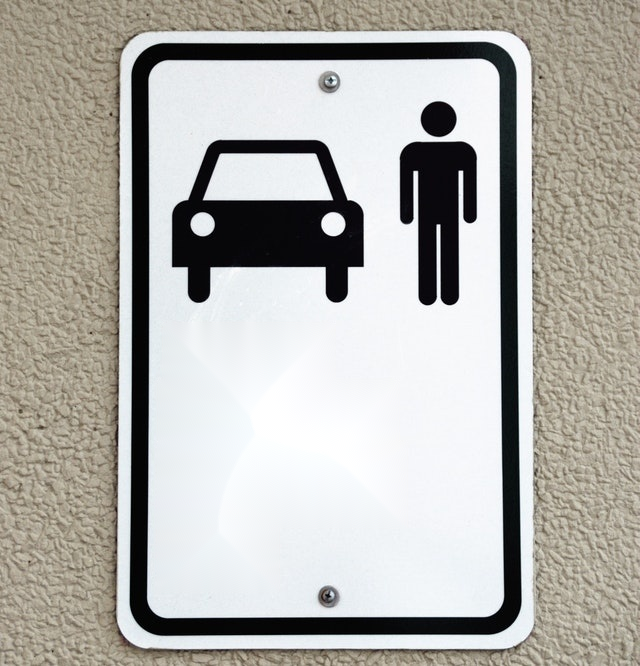

True

In [5]:

# import numpy as np
# import cv2
# from google.colab.patches import cv2_imshow

img = cv2.imread('target.jpg')
mask = cv2.imread('shapes.jpg',0)
dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)
cv2_imshow(dst)

# 저장
cv2.imwrite("inpaint.jpg", dst)

In [15]:
from PIL import Image 
from PIL import ImageFont
from PIL import ImageDraw


# db.set_character_set('utf8')
# dbc.execute('SET NAMES utf8;')
# dbc.execute('SET CHARACTER SET utf8;')
# dbc.execute('SET character_set_connection=utf8;')


# font = ImageFont.load_default()
font = ImageFont.truetype("NotoSansKR-Black.otf", 58)

img = Image.open('inpaint.jpg')


draw = ImageDraw.Draw(img)
# draw.text((163, 323), (333, 385)),"AAAAAAAAAAA!",(0,0,0),font=font)
# draw.text((158, 380), (398, 458)),"BBBBBBB & !",(0,0,0),font=font)
# draw.text((157, 442), (406, 527)),"CCCCCC !",(0,0,0),font=font)
# draw.text((157, 511), (278, 591)),"DDDDD !",(0,0,0),font=font)

# text = "안녕"
# draw.text((0, 150), text, (0, 0, 0), font=font)



# draw.text((163, 323),"환  자 ",(0,0,0),font=font)
# draw.text((158, 380),"픽  업  & ",(0,0,0),font=font)
# draw.text((157, 442),"퇴  원 ",(0,0,0),font=font)
# draw.text((157, 511),"오  직 ",(0,0,0),font=font)

draw.text((163, 323), tranlated_texts[0], (0,0,0), font=font)
draw.text((158, 380), tranlated_texts[1], (0,0,0), font=font)
draw.text((157, 442), tranlated_texts[2], (0,0,0), font=font)
draw.text((157, 511), tranlated_texts[3], (0,0,0), font=font)




# cv2.rectangle(shapes, (163, 323), (333, 385), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (158, 380), (398, 458), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (157, 442), (406, 527), (255, 255, 255), cv2.FILLED)
# cv2.rectangle(shapes, (157, 511), (278, 591), (255, 255, 255), cv2.FILLED)
# Tranlated_texts : ['환자', '픽업 &', '퇴원', '오직']

# draw=ImageDraw.Draw(im)
# draw.text((13,75),"르브론 제임스 \nLA레이커스",font=ImageFont.truetype("SCDream7.otf", 16), fill=(255,255,255)) 
# im.save("title.png")

# img.show()

img.save("img_text.jpg")




In [22]:
# from PIL import Image 
# from PIL import ImageFont
# from PIL import ImageDraw

# # db.set_character_set('utf8')
# # dbc.execute('SET NAMES utf8;')
# # dbc.execute('SET CHARACTER SET utf8;')
# # dbc.execute('SET character_set_connection=utf8;')


# # font = ImageFont.load_default()
# font = ImageFont.truetype("NotoSansKR-Black.otf", 58)

# img = Image.open('inpaint.jpg')

# draw = ImageDraw.Draw(img)


# # draw.text((163, 323), (333, 385)),"AAAAAAAAAAA!",(0,0,0),font=font)
# # draw.text((158, 380), (398, 458)),"BBBBBBB & !",(0,0,0),font=font)
# # draw.text((157, 442), (406, 527)),"CCCCCC !",(0,0,0),font=font)
# # draw.text((157, 511), (278, 591)),"DDDDD !",(0,0,0),font=font)

# # text = "안녕"
# # draw.text((0, 150), text, (0, 0, 0), font=font)

# draw.text((163, 323),"환  자 ",(0,0,0),font=font)
# draw.text((158, 380),"픽  업  & ",(0,0,0),font=font)
# draw.text((157, 442),"퇴  원 ",(0,0,0),font=font)
# draw.text((157, 511),"오  직 ",(0,0,0),font=font)
# # cv2.rectangle(shapes, (163, 323), (333, 385), (255, 255, 255), cv2.FILLED)
# # cv2.rectangle(shapes, (158, 380), (398, 458), (255, 255, 255), cv2.FILLED)
# # cv2.rectangle(shapes, (157, 442), (406, 527), (255, 255, 255), cv2.FILLED)
# # cv2.rectangle(shapes, (157, 511), (278, 591), (255, 255, 255), cv2.FILLED)
# # Tranlated_texts : ['환자', '픽업 &', '퇴원', '오직']

# # draw=ImageDraw.Draw(im)
# # draw.text((13,75),"르브론 제임스 \nLA레이커스",font=ImageFont.truetype("SCDream7.otf", 16), fill=(255,255,255)) 
# # im.save("title.png")

# img.show()
# img.save("imgtext.jpg")



In [9]:
# import PIL
# from PIL import Image,ImageDraw,ImageFont
# import os

# target_image = Image.open('inpaint.jpg')  #일단 기본배경폼 이미지를 open 합니다.
# fontsFolder = 'NanumGothic.ttf'    



# selectedFont = ImageFont.truetype(os.path.join(fontsFolder, 'NanumGothic.ttf'), 24) #폰트경로과 사이즈를 설정해줍니다.
# draw =ImageDraw.Draw(target_image)
# draw.text( ((163, 323), (333, 385)), keyword,fill=(0, 0, 0), font=selectedFont)
# # fill= 속성은 무슨 색으로 채울지 설정,font=는 자신이 설정한 폰트 설정
# target_image.save('imgtext2.jpg') #편집된 이미지를 저장합니다.